# Project Introduction to Neural Networks
# Andres Delgadillo

## 1 Project: Bank Churn Prediction

### 1.1 Objective

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months 

### 1.2 Data Dictionary

- `CustomerId`: Unique ID which is assigned to each customer
- `Surname`: Last name of the customer
- `CreditScore`: It defines the credit history of the customer
- `Geography`: A customer’s location    
- `Gender`: It defines the Gender of the customer   
- `Age`: Age of the customer     
- `Tenure`: Number of years for which the customer has been with the bank
- `NumOfProducts`: It refers to the number of products that a customer has purchased through the bank
- `Balance`: Account balance
- `HasCrCard`: It is a categorical variable that decides whether the customer has a credit card or not.
- `EstimatedSalary`: Estimated salary 
- `isActiveMember`: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
- `Excited`: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values
    - 0=No ( Customer did not leave the bank )
    - 1=Yes ( Customer left the bank )

### 1.3 Questions to be answered
- Why a customer decides to left the bank?
- What are the main characteristics of those customers?
- How the bank could improve the business to avoid customers closing their accounts?

## 2 Import packages and turnoff warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
sns.set(color_codes=True)
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import f1_score,accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


## 3 Import dataset and quality of data

In [2]:
# read data from csv file
data = pd.read_csv('bank.csv')

In [3]:
# get columns
data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [4]:
# get size of dataset
data.shape

(10000, 14)

In [5]:
# check dataset information 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
# check dataset missing values
total = data.isnull().sum().sort_values(ascending=False) # total number of null values
print(total)

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [7]:
# check for duplicates
data.duplicated().sum()

0

This first assessment of the dataset shows:
- There are 10000 rows and 14 features
- There are not missing data
- There are not duplicated rows

## 4 Exploratory Data Analysis

In [8]:
# check first rows of data
data.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [9]:
# check last rows of data
data.tail()

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
9995       5       0.00              2          1               0   
9996      10   57369.61              1          1               1   
9997       7       0.00              1          0               1   
9998       3   75075.31              2          1               0   
9999       4  130142.79              1          1               0   

      EstimatedSalary  Exited  
9995         96270.64       0  
9996        101699.77       0  
9997         42085.58       1  
9998         92888.52       1  
9999         38190.78       0

### 4.1 Pandas profiling report
We can get a first statistical and descriptive analysis using pandas_profiling

In [10]:
# get pandas profiling report
pandas_profiling.ProfileReport(data)

Pandas Profiling report is showing some warnings/characteristics in the data:
- RowNumber and CustomerId have 100% unique values
- Surname has high cardinality with 29.3% unique values
- There is no correlation between variables
- We can drop RowNumber, CustomerId and Surname since they do not impact the classification models

### 4.2 Univariate Analysis

In [11]:
# get stats for the columns
data.describe().T

count          mean           std          min  \
RowNumber        10000.0  5.000500e+03   2886.895680         1.00   
CustomerId       10000.0  1.569094e+07  71936.186123  15565701.00   
CreditScore      10000.0  6.505288e+02     96.653299       350.00   
Age              10000.0  3.892180e+01     10.487806        18.00   
Tenure           10000.0  5.012800e+00      2.892174         0.00   
Balance          10000.0  7.648589e+04  62397.405202         0.00   
NumOfProducts    10000.0  1.530200e+00      0.581654         1.00   
HasCrCard        10000.0  7.055000e-01      0.455840         0.00   
IsActiveMember   10000.0  5.151000e-01      0.499797         0.00   
EstimatedSalary  10000.0  1.000902e+05  57510.492818        11.58   
Exited           10000.0  2.037000e-01      0.402769         0.00   

                         25%           50%           75%          max  
RowNumber            2500.75  5.000500e+03  7.500250e+03     10000.00  
CustomerId       15628528.25  1.569074e+07  1.575323e+07  15815690.00  
CreditScore           584.00  6.520000e+02  7.180000e+02       850.00  
Age                    32.00  3.700000e+01  4.400000e+01        92.00  
Tenure                  3.00  5.000000e+00  7.000000e+00        10.00  
Balance                 0.00  9.719854e+04  1.276442e+05    250898.09  
NumOfProducts           1.00  1.000000e+00  2.000000e+00         4.00  
HasCrCard               0.00  1.000000e+00  1.000000e+00         1.00  
IsActiveMember          0.00  1.000000e+00  1.000000e+00         1.00  
EstimatedSalary     51002.11  1.001939e+05  1.493882e+05    199992.48  
Exited                  0.00  0.000000e+00  0.000000e+00         1.00

- **CreditScore**
    - CreditScore is between 350 and 850
    - Average is 650 and Median 652
    - There are not outliers
- **Geography**
    - There are 3 categories: France (50.1%), Germany (25.1%) and Spain (24.8%)
- **Gender**
    - There are 2 categories: Male (54.6%) and Female (45.4%)
- **Age**
    - Age is between 18 and 92
    - Average is 38.9 and Median 37
    - There are not outliers
- **Tenure**
    - Tenure is between 0 and 10
    - Average is 5 and Median is 5
    - There are not outliers
- **Balance**
    - Balance is between 0 and 250898
    - Average is 76485 and Median is 97198
- **NumOfProducts**
    - NumOfProducts is between 1 and 4
    - Average is 1.53 and Median 2
    - There are not outliers
- **HasCrCard**
    - There are 2 categories: 1 (70.5%) and 0 (29.4%)
- **IsActiveMember**
    - There are 2 categories: 1 (51.5%) and 0 (48.5%)
- **EstimatedSalary**
    - EstimatedSalary is between 11.58 and 199992.48
    - Average is 100090 and Median 149388
    - It is uniformly distributed
- **Exited**
    - There are 2 categories: 0	(79.6%) and 1 (20.4%)

###  4.3 Pairplot.
We are going to perform bivariate analysis to understand the relationship between the columns

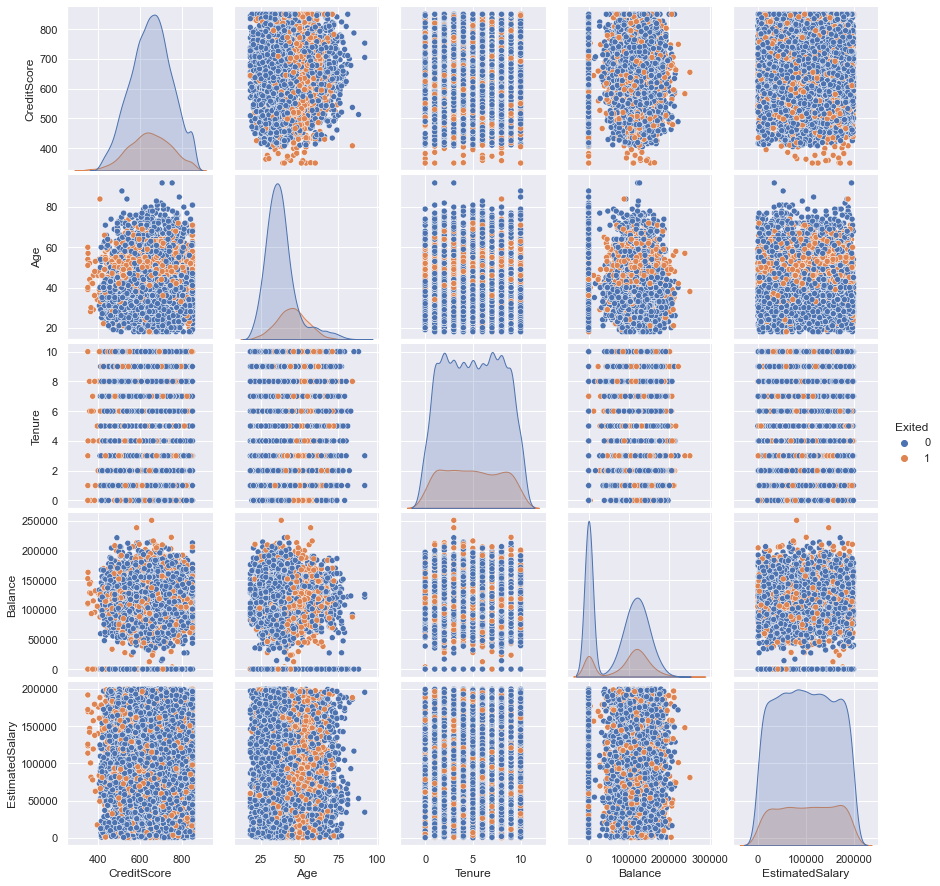

In [12]:
# Continuous columns + Exited
con_col = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Exited']
# Pairplot for continuous columns
sns.pairplot(data[con_col], diag_kind='kde', hue='Exited');

### 4.4 Bivariate and Multivariate Analysis

In [13]:
# Get correlation matrix for numeric variables
data[con_col].corr()

CreditScore       Age    Tenure   Balance  EstimatedSalary  \
CreditScore         1.000000 -0.003965  0.000842  0.006268        -0.001384   
Age                -0.003965  1.000000 -0.009997  0.028308        -0.007201   
Tenure              0.000842 -0.009997  1.000000 -0.012254         0.007784   
Balance             0.006268  0.028308 -0.012254  1.000000         0.012797   
EstimatedSalary    -0.001384 -0.007201  0.007784  0.012797         1.000000   
Exited             -0.027094  0.285323 -0.014001  0.118533         0.012097   

                   Exited  
CreditScore     -0.027094  
Age              0.285323  
Tenure          -0.014001  
Balance          0.118533  
EstimatedSalary  0.012097  
Exited           1.000000

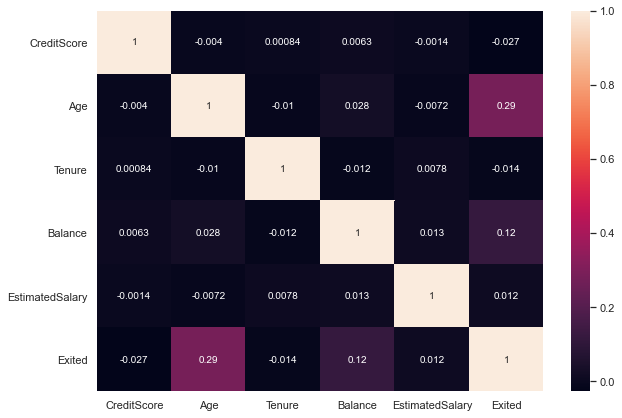

In [14]:
# Display correlation matrix in a heatmap
fig, ax = plt.subplots(figsize=(10,7)) 
sns.heatmap(data[con_col].corr(), annot=True, ax=ax);

- Correlation between features is low

#### 4.4.1 Exited and Continuous features

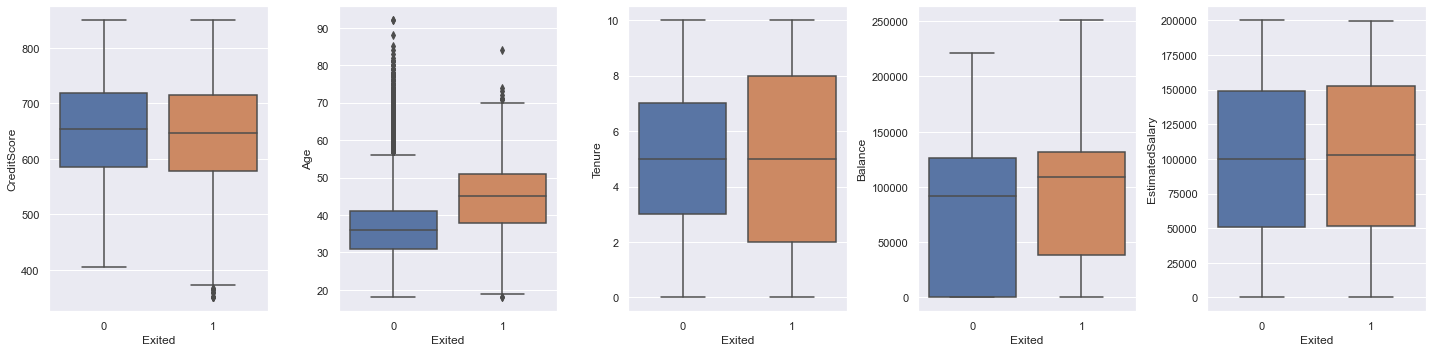

In [15]:
# Create subplots for the different boxplot charts
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
i = 0
for feature in con_col:
    if feature != 'Exited':
        # display the boxplot
        sns.boxplot(data['Exited'], data[feature], ax=axes[i], )
        i+=1

plt.tight_layout()
plt.show()

**Observations**
- CreditScore has similar upper whisker and median values for both Exited categories. However, lower whisker is lower for customers that leave the bank
- Age of customers that do not leave the bank is lower than customers that leave the bank
- The range between Tenure lower and upper quartiles is higher for customers that leave the bank
- Balance for customers that do not leave the bank is lower than customers leaving the bank
- Estimated salary has similar distribution for both Exited categories

#### 4.4.2 Exited and Geography

In [16]:
### Function to plot stacked bar charts for categorical columns
def stacked_plot(x,hue):
    tab = 100*pd.crosstab(x,hue,normalize='index').sort_values(by=hue[0])
    print(tab.T)
    tab.plot(kind='bar',stacked=True)

Geography     France      Spain    Germany
Exited                                    
0          83.845233  83.326605  67.556796
1          16.154767  16.673395  32.443204


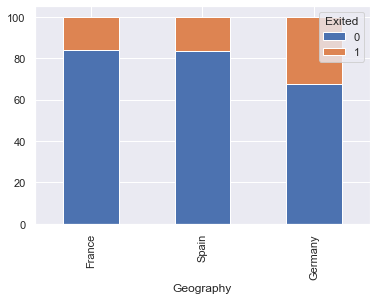

In [17]:
# Plot the stacked plot
stacked_plot(data['Geography'], data['Exited'])

- Germany has more customers leaving the bank

#### 4.4.3 Exited and Gender

Gender       Male     Female
Exited                      
0       83.544072  74.928461
1       16.455928  25.071539


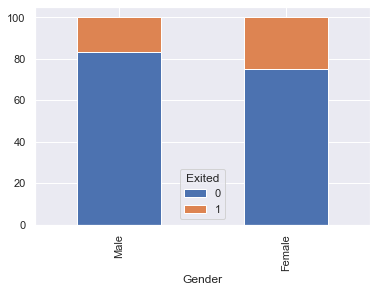

In [18]:
# Plot the stacked plot
stacked_plot(data['Gender'], data['Exited'])

- Female customers leave the bank in higher proportion than Male customers

#### 4.4.4 Exited and NumOfProducts

NumOfProducts          2          1          3      4
Exited                                               
0              92.418301  72.285602  17.293233    0.0
1               7.581699  27.714398  82.706767  100.0


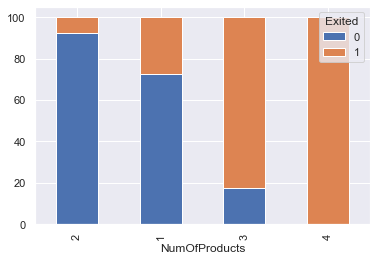

In [19]:
# Plot the stacked plot
stacked_plot(data['NumOfProducts'], data['Exited'])

- 100% of customers with 4 products, and 82% of customers with 3 products leave the bank

#### 4.4.5 Exited and HasCrCard

HasCrCard          1          0
Exited                         
0          79.815734  79.185059
1          20.184266  20.814941


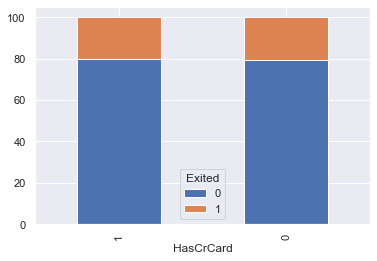

In [20]:
# Plot the stacked plot
stacked_plot(data['HasCrCard'], data['Exited'])

- There is no difference between customers with and without credit cards

#### 4.4.6 Exited and IsActiveMember

IsActiveMember          1          0
Exited                              
0               85.730926  73.149103
1               14.269074  26.850897


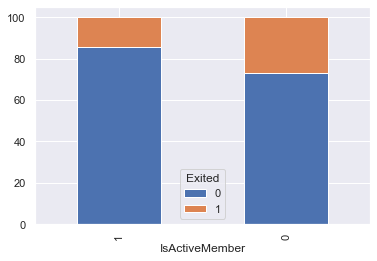

In [21]:
# Plot the stacked plot
stacked_plot(data['IsActiveMember'], data['Exited'])

- Non-active members leave the bank in higher proportion than active members

## 5 Data Pre-Processing

### 5.1 Feature Engineering
- Drop RowNumber, CustomerId and Surname columns
- Hot encoding Geography and Gender

In [22]:
# Drop RowNumber column
data.drop(['RowNumber'], axis=1, inplace=True)
# Drop CustomerId column
data.drop(['CustomerId'], axis=1, inplace=True)
# Drop Surname column
data.drop(['Surname'], axis=1, inplace=True)

### 5.2 Data Preparation for Modeling
#### 5.2.1 Training, validation and test sets

In [23]:
# create independent variables
X = data.drop(['Exited'], axis=1)
# create dependent variable
y = data['Exited']

In [24]:
# Splitting data into training, validation and test set:
# first we split data into 2 parts, say temporary and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# then we split the temporary set into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp)

print(f'Shape of Training set: {X_train.shape}')
print(f'Shape of Validation set: {X_val.shape}')
print(f'Shape of Test set: {X_test.shape}')
print(f'Percentage of classes in Training set\n{y_train.value_counts(normalize=True)}')
print(f'Percentage of classes in Validation set\n{y_val.value_counts(normalize=True)}')
print(f'Percentage of classes in Test set\n{y_test.value_counts(normalize=True)}')

Shape of Training set: (6000, 10)
Shape of Validation set: (2000, 10)
Shape of Test set: (2000, 10)
Percentage of classes in Training set
0    0.796333
1    0.203667
Name: Exited, dtype: float64
Percentage of classes in Validation set
0    0.796
1    0.204
Name: Exited, dtype: float64
Percentage of classes in Test set
0    0.7965
1    0.2035
Name: Exited, dtype: float64


- Training, validation and test set have similar ratios of classes for Exited feature

#### 5.2.2 Creating Dummy Variables

In [25]:
# hot encoding for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
print(X_train.shape, X_val.shape, X_test.shape)

(6000, 11) (2000, 11) (2000, 11)


- After hot encoding there are 11 columns

### 5.3 Scaling Data

In [26]:
# Scaling the data using z-score
scaler = StandardScaler()

columns = X_train.columns
# Fit and transform the train data
X_train[columns] = scaler.fit_transform(X_train[columns])
# Transform the validation data
X_val[columns] = scaler.transform(X_val[columns])
# Transform the test data
X_test[columns] = scaler.transform(X_test[columns])

## 6 Models evaluation criteria

### 6.1 Insights:

- **True Positives:**
    - Reality: The account is closed and the customer leaves the bank
    - Model predicted: The customer leaves the bank
    - Outcome: The bank can identify the characteristics of the customers that close their accounts
    
- **True Negatives:**
    - Reality: The account is open and the customer does not leave the bank
    - Model predicted: The customer does not leave the bank
    - Outcome: The model is good, and customer is keeping the accounts

- **False Positives:**
    - Reality: The account is open and the customer does not leave the bank
    - Model predicted: The customer leaves the bank
    - Outcome: The bank is not classifying correctly the customers that are closing their accounts
    
- **False Negatives:**
    - Reality: The account is closed and the customer leaves the bank
    - Model predicted: The customer does not leave the bank
    - Outcome: The bank is not classifying correctly the customers that are not closing their accounts

#### 6.1.1 Model can make wrong predictions as:
1. Predicting a customer leaves the bank but actually the customer keeps the accounts
2. Predicting a customer does not leave the bank but actually the customer closes the accounts

#### 6.1.2 Which case is more important? 
- Case 2 is more important because the bank needs to identify correctly the customers that are closing their accounts

#### 6.1.3 How to reduce this loss?
*  `Recall` should be used as a measured of the model performance. High recall score implies low False Negatives

### 6.2 Functions to evaluate models
- metrics_score: check the model performance of models. 
- make_confusion_matrix: plot confusion matrix.

In [27]:
# Function to calculate different metric scores of the classification model
def metrics_score(model,train,test,train_y,test_y,threshold=0.5,model_name=''):
    '''
    Inputs:
        model: classifier to predict values of X
        train, test: Independent features in train and test sets
        train_y,test_y: Dependent variable in train and test sets
        threshold: thresold for classifiying the observation as 1
        model_name: Name of the model
    '''
    
    # Make the prediction of the model in train and test sets
    pred_train = (model.predict(train)>threshold)
    pred_test = (model.predict(test)>threshold)

    # Calculate scores and save them in a dictionary
    score_dict = {'Model':model_name,
                  'Accuracy on training set' : accuracy_score(pred_train,train_y),
                  'Accuracy on validation set': accuracy_score(pred_test,test_y),
                  'Recall on training set': recall_score(train_y,pred_train),
                  'Recall on validation set': recall_score(test_y,pred_test),
                  'Precision on training set': precision_score(train_y,pred_train),
                  'Precision on validation set': precision_score(test_y,pred_test),
                  'F1 on training set': f1_score(train_y,pred_train),
                  'F1 on validation set': f1_score(test_y,pred_test)
                 }
    # Create a dataframe with scores
    scores = pd.DataFrame(score_dict,index=[0])
    # return the df
    return scores

In [28]:
# Function to display the confusion matrix 
def make_confusion_matrix(model,test_X,y_actual,threshold=0.5,labels=[1, 0]):
    '''
    Inputs:
        model : classifier to predict values of X
        test_X: test set
        y_actual : ground truth  
        threshold: thresold for classifiying the observation as 1
    '''
    # Make prediction of the model
    y_predict = (model.predict(test_X) > threshold).astype('float')
    # calculate the confusion matrix
    cm = metrics.confusion_matrix( y_actual, y_predict, labels=[1,0])
    # create a dataframe to display the heatmap
    df_cm = pd.DataFrame(cm, 
                         index = ['Actual-Attritied Customer','Actual-Existing Customer'],
                         columns = ['Predicted-Attritied Customer','Predicted-Existing Customer'])
    # calculate the number of percentage of the confusion matrix for each category
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.1%}".format(value) for value in cm.flatten()/np.sum(cm)]
    # create labels
    group_labels = ['(TP)', '(FN)', '(FP)', '(TN)']
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_counts,group_percentages,group_labels)]
    labels = np.asarray(labels).reshape(2,2)
    # display the confusion matrix in a heatmap
    plt.figure(figsize = (8,6))
    sns.heatmap(df_cm, annot=labels, fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
# Function to plot training results by epoch
def plot_hist(hist):
    # Capturing learning history per epoch
    hist  = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Plotting loss at different epochs
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('Loss')
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.legend(("train" , "valid") , loc =0);

    # Plotting recall at different epochs
    plt.subplot(122)
    plt.title('Recall')
    plt.plot(hist['recall'])
    plt.plot(hist['val_recall'])
    plt.legend(("train" , "valid") , loc =0);

In [30]:
# Function to calculate optimal threshold as per AUC-ROC curve
def optimal_threshold(X_val, y_val, model):
    # The optimal cut off would be where tpr is high and fpr is low
    fpr, tpr, thresholds = metrics.roc_curve(y_val, model.predict(X_val))

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold_auc_roc = thresholds[optimal_idx]
    print(optimal_threshold_auc_roc)
    return optimal_threshold_auc_roc

## 7 Model Building - Neural Network
### 7.1 Creating the model
Now, we are going to create the Neural Network using Keras

In [31]:
# Initialize seed for random numbers
np.random.seed(1)
tf.random.set_seed(1)

# Initialize the model
model = Sequential()

## Adding layers
# Input Layer and first hidden layer
model.add(Dense(units=10, input_dim = 11, activation='elu', kernel_initializer='random_normal'))   # input of 11 columns as shown above
# Hidden layer
model.add(Dense(units=10, activation='elu', kernel_initializer='random_normal'))
# Adding Dropout to prevent overfitting 
model.add(Dropout(0.5))
# Output layer
model.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

We are going to compile the model using:
- optimizer: Adam
- loss function: binary_crossentropy
- metrics: Recall

In [32]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01),loss='binary_crossentropy',metrics=['Recall'])

**Summary of the model**

In [33]:
# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


### 7.2 Training (Forward and Backpropagation)
Now, we are going to train the model using 100 epochs

In [34]:
#fitting the model
history=model.fit(X_train,y_train,batch_size=32,epochs=200,validation_split=0.2)

Epoch 1/200
150/150 [==============================] - 1s 3ms/step - loss: 0.4812 - recall: 0.1805 - val_loss: 0.4141 - val_recall: 0.1498
Epoch 2/200
150/150 [==============================] - 0s 1ms/step - loss: 0.4368 - recall: 0.2154 - val_loss: 0.3737 - val_recall: 0.4332
Epoch 3/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3881 - recall: 0.3374 - val_loss: 0.3369 - val_recall: 0.5061
Epoch 4/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3712 - recall: 0.3897 - val_loss: 0.3353 - val_recall: 0.5263
Epoch 5/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3655 - recall: 0.4267 - val_loss: 0.3304 - val_recall: 0.5466
Epoch 6/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3686 - recall: 0.4154 - val_loss: 0.3320 - val_recall: 0.4251
Epoch 7/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3611 - recall: 0.4226 - val_loss: 0.3217 - val_recall: 0.4980
Epoch 8/200
150/150 [======

150/150 [==============================] - 0s 1ms/step - loss: 0.3475 - recall: 0.4195 - val_loss: 0.3327 - val_recall: 0.4696
Epoch 118/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3457 - recall: 0.4277 - val_loss: 0.3301 - val_recall: 0.4656
Epoch 119/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3453 - recall: 0.4256 - val_loss: 0.3235 - val_recall: 0.5020
Epoch 120/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3432 - recall: 0.4297 - val_loss: 0.3279 - val_recall: 0.5344
Epoch 121/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3431 - recall: 0.4154 - val_loss: 0.3339 - val_recall: 0.4737
Epoch 122/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3497 - recall: 0.4236 - val_loss: 0.3264 - val_recall: 0.5061
Epoch 123/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3456 - recall: 0.4123 - val_loss: 0.3289 - val_recall: 0.4737
Epoch 124/200
150/150 [====

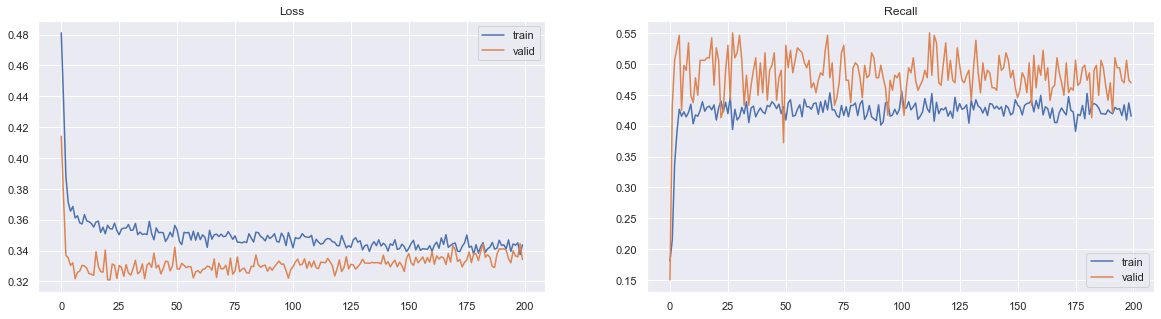

In [35]:
# plot loss and recall
plot_hist(history)

**Observation**
- The training of the neural network did not converge smoothly and loss in validation is jumping in a big range. Therefore, we need to change the learning rate in the optimizer.

### 7.3 ROC-AUC
Now, we are going to analyze the ROC-AUC in the training and validation sets

**Training set**

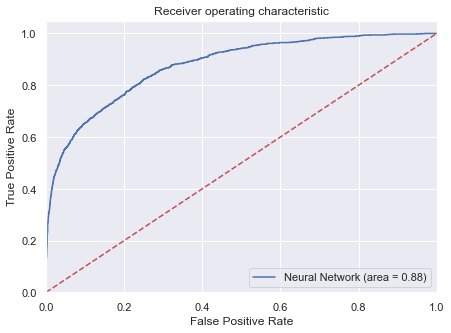

In [36]:
roc_auc_train = roc_auc_score(y_train, model.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, model.predict(X_train))
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Neural Network (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

**Validation set**

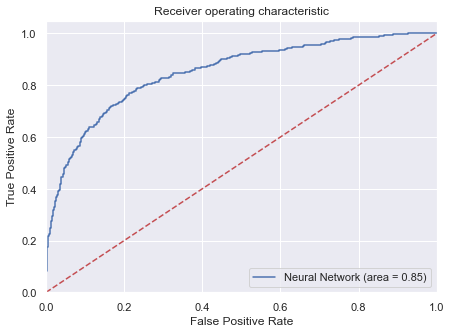

In [37]:
roc_auc_train = roc_auc_score(y_val, model.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val, model.predict(X_val))
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='Neural Network (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Determine the optimal threshold from AUC-ROC curve

In [38]:
# determine optimal threshold
optimal_threshold_auc_roc_1 = optimal_threshold(X_val, y_val, model)

0.21450984


### 7.4 Model performance
Now, we are going to calculate the different metrics and evaluate the performance of the model in train and validation sets

In [39]:
# checking model performances for this model in train and validation sets
scores_nn = metrics_score(model,X_train,X_val,y_train,y_val,threshold=optimal_threshold_auc_roc_1,model_name='AUC-ROC')
scores_nn

Model  Accuracy on training set  Accuracy on validation set  \
0  AUC-ROC                     0.778                       0.783   

   Recall on training set  Recall on validation set  \
0                0.795417                  0.767157   

   Precision on training set  Precision on validation set  F1 on training set  \
0                   0.473223                     0.480061            0.593407   

   F1 on validation set  
0              0.590566

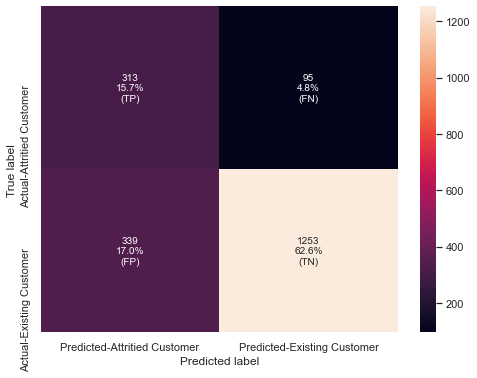

In [40]:
# creating confusion matrix
make_confusion_matrix(model,X_val,y_val, threshold=optimal_threshold_auc_roc_1)

**Observations**
- The neural network model presents similar performance on both training and validation sets. That means the model is not overfitting and would have good performance on production
- Recall scores are above 0.76 in both training and validation sets
- Precision and F1-score in both training and validation sets are small. However, this is not an issue because we want to identify correctly the customers that leave the bank and the model is maximizing the Recall score

## 8 Model Performance Improvement
We are going to try different strategies to improve the model performance:
- Adding Early Stopping
- Change the learning rate in the optimizer
- Weight initialization
- Add more hidden layers to the neural network
- Weighted loss to account for class imbalance

**Early Stopping Callback**

We will use early stopping callback in each model

In [41]:
# Creating earlystopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  min_delta=0, 
                                                  patience=20,
                                                  verbose=0, mode='min', 
                                                  restore_best_weights= True)

### 8.1 Change learning rate


In [42]:
# Initialize seed for random numbers
np.random.seed(1)
tf.random.set_seed(1)

# Create a copy of the model (with freshly initialized weights)
model_2 = tf.keras.models.clone_model(model)
# change learning rate to 0.0005
model_2.compile(optimizer=Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['Recall'])
#fitting the model
history = model_2.fit(X_train,y_train,batch_size=32,epochs=200,validation_split=0.2,callbacks=[early_stopping])

Epoch 1/200
150/150 [==============================] - 1s 2ms/step - loss: 0.6648 - recall: 0.0297 - val_loss: 0.6102 - val_recall: 0.1053
Epoch 2/200
150/150 [==============================] - 0s 1ms/step - loss: 0.5326 - recall: 0.1477 - val_loss: 0.4514 - val_recall: 0.2146
Epoch 3/200
150/150 [==============================] - 0s 1ms/step - loss: 0.4572 - recall: 0.1805 - val_loss: 0.4185 - val_recall: 0.2267
Epoch 4/200
150/150 [==============================] - 0s 1ms/step - loss: 0.4490 - recall: 0.1826 - val_loss: 0.4134 - val_recall: 0.2470
Epoch 5/200
150/150 [==============================] - 0s 1ms/step - loss: 0.4473 - recall: 0.2000 - val_loss: 0.4119 - val_recall: 0.2429
Epoch 6/200
150/150 [==============================] - 0s 1ms/step - loss: 0.4493 - recall: 0.2041 - val_loss: 0.4120 - val_recall: 0.2551
Epoch 7/200
150/150 [==============================] - 0s 2ms/step - loss: 0.4481 - recall: 0.2021 - val_loss: 0.4106 - val_recall: 0.2632
Epoch 8/200
150/150 [======

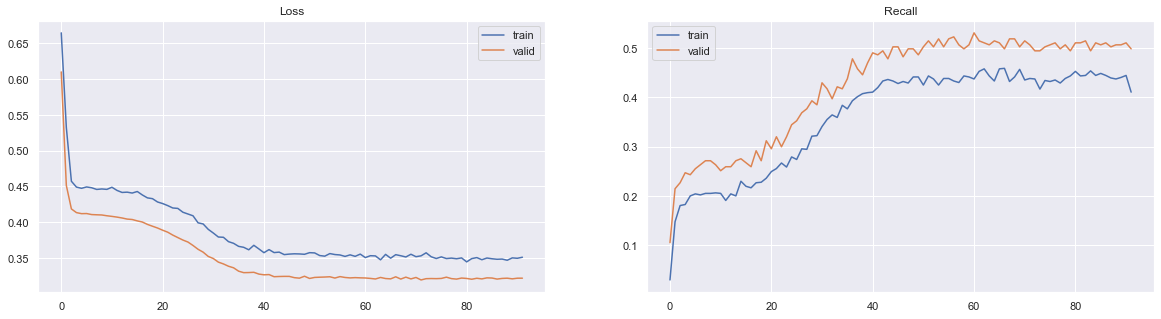

In [43]:
# plot loss and recall
plot_hist(history)

In [44]:
# determine optimal threshold
optimal_threshold_auc_roc_2 = optimal_threshold(X_val, y_val, model_2)

0.18675604


In [45]:
# checking model performances for this model in train and validation sets
scores_nn2 = metrics_score(model_2,X_train,X_val,y_train,y_val,threshold=optimal_threshold_auc_roc_2,model_name='Model 2')
scores_nn2

Model  Accuracy on training set  Accuracy on validation set  \
0  Model 2                  0.781667                      0.7875   

   Recall on training set  Recall on validation set  \
0                0.767594                   0.77451   

   Precision on training set  Precision on validation set  F1 on training set  \
0                   0.477597                     0.486903            0.588826   

   F1 on validation set  
0              0.597919

### 8.2 Add more hidden layers

In [46]:
# Initialize seed for random numbers
np.random.seed(1)
tf.random.set_seed(1)
#initialize the model
model_3 = Sequential()
## Adding layers
# Input Layer and first hidden layer
model_3.add(Dense(units=10, input_dim = 11,activation='elu'))   # input of 11 columns as shown above
# Hidden layers
model_3.add(Dense(units=10,activation='elu'))
# Adding Dropout to prevent overfitting 
model_3.add(Dropout(0.5))
model_3.add(Dense(25,activation='elu'))
model_3.add(Dense(25,activation='elu'))
# Output layer
model_3.add(Dense(1,activation='sigmoid'))

In [47]:
# Compile the model
model_3.compile(optimizer=Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['Recall'])

In [48]:
# Summary
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                120       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 25)                275       
_________________________________________________________________
dense_6 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 1,181
Trainable params: 1,181
Non-trainable params: 0
____________________________________________________

In [49]:
#fitting the model
history=model_3.fit(X_train,y_train,batch_size=32,epochs=200,validation_split=0.2,callbacks=[early_stopping])

Epoch 1/200
150/150 [==============================] - 1s 3ms/step - loss: 0.5892 - recall: 0.1979 - val_loss: 0.4860 - val_recall: 0.0040
Epoch 2/200
150/150 [==============================] - 0s 1ms/step - loss: 0.4906 - recall: 0.0554 - val_loss: 0.4452 - val_recall: 0.0972
Epoch 3/200
150/150 [==============================] - 0s 1ms/step - loss: 0.4634 - recall: 0.0821 - val_loss: 0.4257 - val_recall: 0.1174
Epoch 4/200
150/150 [==============================] - 0s 1ms/step - loss: 0.4602 - recall: 0.0831 - val_loss: 0.4167 - val_recall: 0.1700
Epoch 5/200
150/150 [==============================] - 0s 1ms/step - loss: 0.4515 - recall: 0.1149 - val_loss: 0.4093 - val_recall: 0.2105
Epoch 6/200
150/150 [==============================] - 0s 1ms/step - loss: 0.4453 - recall: 0.1559 - val_loss: 0.4032 - val_recall: 0.2227
Epoch 7/200
150/150 [==============================] - 0s 1ms/step - loss: 0.4436 - recall: 0.1600 - val_loss: 0.4026 - val_recall: 0.1943
Epoch 8/200
150/150 [======

150/150 [==============================] - 0s 1ms/step - loss: 0.3439 - recall: 0.4574 - val_loss: 0.3189 - val_recall: 0.5061
Epoch 118/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3456 - recall: 0.4585 - val_loss: 0.3200 - val_recall: 0.5304
Epoch 119/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3446 - recall: 0.4605 - val_loss: 0.3183 - val_recall: 0.5020
Epoch 120/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3471 - recall: 0.4400 - val_loss: 0.3227 - val_recall: 0.5587
Epoch 121/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3483 - recall: 0.4421 - val_loss: 0.3207 - val_recall: 0.5061
Epoch 122/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3470 - recall: 0.4462 - val_loss: 0.3194 - val_recall: 0.5142
Epoch 123/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3446 - recall: 0.4636 - val_loss: 0.3196 - val_recall: 0.5101
Epoch 124/200
150/150 [====

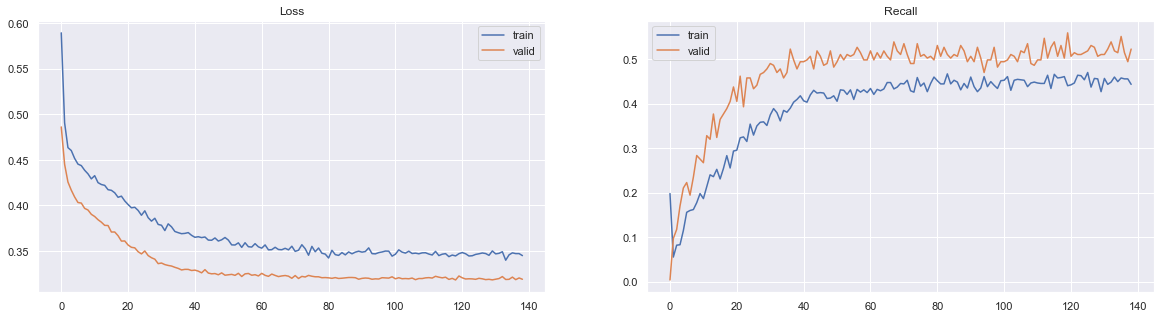

In [50]:
# plot loss and recall
plot_hist(history)

In [51]:
# determine optimal threshold
optimal_threshold_auc_roc_3 = optimal_threshold(X_val, y_val, model_3)

0.16913718


In [52]:
# checking model performances for this model in train and validation sets
scores_nn3 = metrics_score(model_3,X_train,X_val,y_train,y_val,threshold=optimal_threshold_auc_roc_3,model_name='Model 3')
scores_nn3

Model  Accuracy on training set  Accuracy on validation set  \
0  Model 3                     0.784                       0.797   

   Recall on training set  Recall on validation set  \
0                0.774959                  0.767157   

   Precision on training set  Precision on validation set  F1 on training set  \
0                   0.481199                     0.501603             0.59373   

   F1 on validation set  
0              0.606589

### 8.3 Weight Initialization

In [53]:
# Initialize seed for random numbers
np.random.seed(1)
tf.random.set_seed(1)
#initialize the model
model_4 = Sequential()

## Adding layers
# Input Layer
model_4.add(Dense(units=10, input_dim = 11, kernel_initializer='he_normal', activation='elu'))   # input of 11 columns as shown above
# Hidden layer
model_4.add(Dense(units=10, kernel_initializer='he_normal', activation='elu'))
# Adding Dropout to prevent overfitting 
model_4.add(Dropout(0.5))
# Output layer
model_4.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

In [54]:
# Compile the model
model_4.compile(optimizer=Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['Recall'])

In [55]:
# Summary
model_4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10)                120       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


In [56]:
#fitting the model
history=model_4.fit(X_train,y_train,batch_size=32,epochs=200,validation_split=0.2,callbacks=[early_stopping])

Epoch 1/200
150/150 [==============================] - 1s 2ms/step - loss: 0.8987 - recall: 0.5415 - val_loss: 0.6007 - val_recall: 0.4575
Epoch 2/200
150/150 [==============================] - 0s 1ms/step - loss: 0.7283 - recall: 0.4113 - val_loss: 0.5095 - val_recall: 0.3320
Epoch 3/200
150/150 [==============================] - 0s 1ms/step - loss: 0.6277 - recall: 0.3579 - val_loss: 0.4706 - val_recall: 0.2591
Epoch 4/200
150/150 [==============================] - 0s 1ms/step - loss: 0.5714 - recall: 0.3097 - val_loss: 0.4517 - val_recall: 0.2267
Epoch 5/200
150/150 [==============================] - 0s 1ms/step - loss: 0.5582 - recall: 0.2677 - val_loss: 0.4409 - val_recall: 0.2065
Epoch 6/200
150/150 [==============================] - 0s 1ms/step - loss: 0.5304 - recall: 0.2554 - val_loss: 0.4348 - val_recall: 0.2065
Epoch 7/200
150/150 [==============================] - 0s 1ms/step - loss: 0.5148 - recall: 0.2410 - val_loss: 0.4306 - val_recall: 0.2065
Epoch 8/200
150/150 [======

150/150 [==============================] - 0s 1ms/step - loss: 0.3542 - recall: 0.4154 - val_loss: 0.3231 - val_recall: 0.5061
Epoch 118/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3560 - recall: 0.4287 - val_loss: 0.3245 - val_recall: 0.5223
Epoch 119/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3535 - recall: 0.4287 - val_loss: 0.3230 - val_recall: 0.5101
Epoch 120/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3509 - recall: 0.4297 - val_loss: 0.3237 - val_recall: 0.5223
Epoch 121/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3508 - recall: 0.4287 - val_loss: 0.3240 - val_recall: 0.5182
Epoch 122/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3551 - recall: 0.4154 - val_loss: 0.3237 - val_recall: 0.5061
Epoch 123/200
150/150 [==============================] - 0s 1ms/step - loss: 0.3518 - recall: 0.4092 - val_loss: 0.3232 - val_recall: 0.5142
Epoch 124/200
150/150 [====

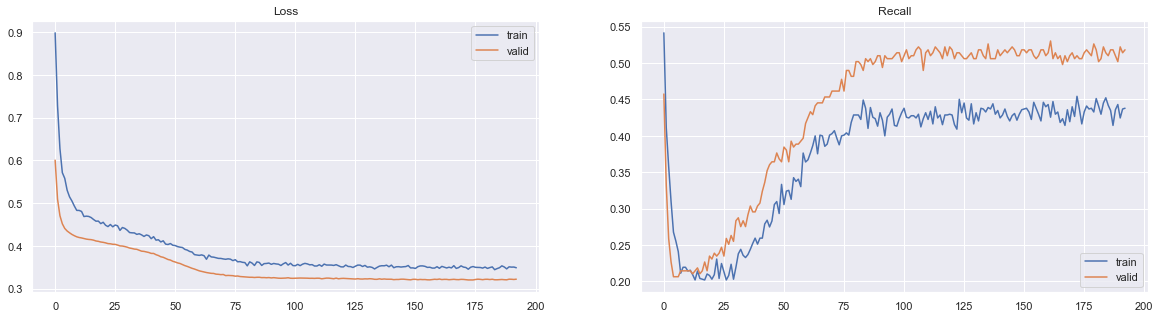

In [57]:
# plot loss and recall
plot_hist(history)

In [58]:
# determine optimal threshold
optimal_threshold_auc_roc_4 = optimal_threshold(X_val, y_val, model_4)

0.19439223


In [59]:
# checking model performances for this model in train and validation sets
scores_nn4 = metrics_score(model_4,X_train,X_val,y_train,y_val,threshold=optimal_threshold_auc_roc_4,model_name='Model 4')
scores_nn4

Model  Accuracy on training set  Accuracy on validation set  \
0  Model 4                    0.7895                       0.797   

   Recall on training set  Recall on validation set  \
0                0.760229                  0.757353   

   Precision on training set  Precision on validation set  F1 on training set  \
0                   0.489205                     0.501623            0.595322   

   F1 on validation set  
0              0.603516

### 8.4 Weighted loss to account for large class imbalance

In [60]:
# calculate class weights
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), np.array([y_train.iloc[i] for i in range(len(y_train))]))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6278777731268314, 1: 2.454991816693944}

In [61]:
# Initialize seed for random numbers
np.random.seed(1)
tf.random.set_seed(1)

# Create a copy of the model (with freshly initialized weights)
model_5 = tf.keras.models.clone_model(model_4)
# change learning rate to 0.0005
model_5.compile(optimizer=Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['Recall'])
#fitting the model
history = model_5.fit(X_train,y_train,batch_size=32,epochs=200,validation_split=0.2,class_weight=class_weights,callbacks=[early_stopping])

Epoch 1/200
150/150 [==============================] - 1s 3ms/step - loss: 0.9369 - recall: 0.5938 - val_loss: 0.7215 - val_recall: 0.7045
Epoch 2/200
150/150 [==============================] - 0s 1ms/step - loss: 0.8486 - recall: 0.5754 - val_loss: 0.6782 - val_recall: 0.7490
Epoch 3/200
150/150 [==============================] - 0s 1ms/step - loss: 0.7705 - recall: 0.6082 - val_loss: 0.6483 - val_recall: 0.7611
Epoch 4/200
150/150 [==============================] - 0s 2ms/step - loss: 0.7304 - recall: 0.5969 - val_loss: 0.6293 - val_recall: 0.7692
Epoch 5/200
150/150 [==============================] - 0s 1ms/step - loss: 0.7212 - recall: 0.6051 - val_loss: 0.6159 - val_recall: 0.7692
Epoch 6/200
150/150 [==============================] - 0s 1ms/step - loss: 0.6936 - recall: 0.6113 - val_loss: 0.6098 - val_recall: 0.7652
Epoch 7/200
150/150 [==============================] - 0s 1ms/step - loss: 0.6749 - recall: 0.6051 - val_loss: 0.6021 - val_recall: 0.7652
Epoch 8/200
150/150 [======

150/150 [==============================] - 0s 1ms/step - loss: 0.4826 - recall: 0.7446 - val_loss: 0.4442 - val_recall: 0.7611
Epoch 118/200
150/150 [==============================] - 0s 1ms/step - loss: 0.4865 - recall: 0.7508 - val_loss: 0.4548 - val_recall: 0.7733
Epoch 119/200
150/150 [==============================] - 0s 1ms/step - loss: 0.4833 - recall: 0.7487 - val_loss: 0.4427 - val_recall: 0.7530
Epoch 120/200
150/150 [==============================] - 0s 1ms/step - loss: 0.4768 - recall: 0.7364 - val_loss: 0.4494 - val_recall: 0.7692
Epoch 121/200
150/150 [==============================] - 0s 1ms/step - loss: 0.4780 - recall: 0.7364 - val_loss: 0.4463 - val_recall: 0.7652
Epoch 122/200
150/150 [==============================] - 0s 1ms/step - loss: 0.4824 - recall: 0.7426 - val_loss: 0.4428 - val_recall: 0.7611
Epoch 123/200
150/150 [==============================] - 0s 1ms/step - loss: 0.4769 - recall: 0.7456 - val_loss: 0.4407 - val_recall: 0.7652
Epoch 124/200
150/150 [====

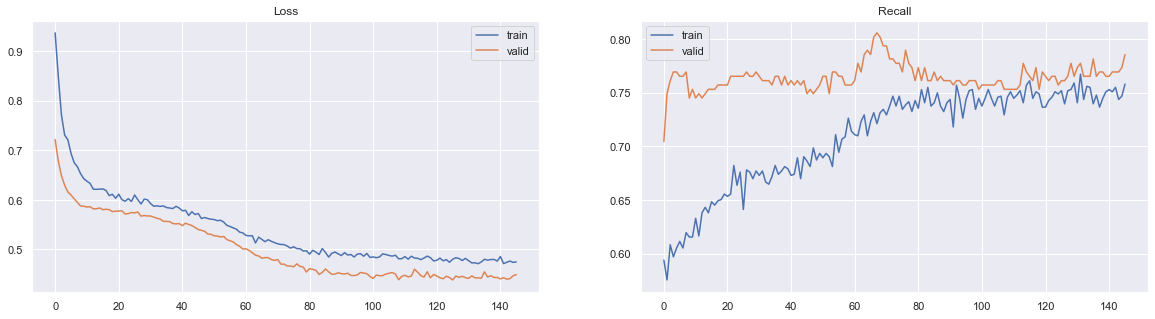

In [62]:
# plot loss and recall
plot_hist(history)

In [63]:
# determine optimal threshold
optimal_threshold_auc_roc_5 = optimal_threshold(X_val, y_val, model_5)

0.48185006


In [64]:
# checking model performances for this model in train and validation sets
scores_nn5 = metrics_score(model_5,X_train,X_val,y_train,y_val,threshold=optimal_threshold_auc_roc_5,model_name='Model 5')
scores_nn5

Model  Accuracy on training set  Accuracy on validation set  \
0  Model 5                  0.783833                       0.792   

   Recall on training set  Recall on validation set  \
0                0.758592                  0.762255   

   Precision on training set  Precision on validation set  F1 on training set  \
0                    0.48056                     0.493651            0.588385   

   F1 on validation set  
0              0.599229

## 9 Model performances on test set
Now, we are going to compare all models on test set

In [65]:
# Function to calculate different metric scores of the classification model
def metrics_score_test(model,test,test_y,threshold=0.5,model_name=''):
    '''
    Inputs:
        model: classifier to predict values of X
        test: Independent features in test sets
        test_y: Dependent variable in test sets
        threshold: thresold for classifiying the observation as 1
        model_name: Name of the model
    '''
    
    # Make the prediction of the model in train and test sets
    pred_test = (model.predict(test)>threshold)

    # Calculate scores and save them in a dictionary
    score_dict = {'Model':model_name,
                  'Accuracy on test set': accuracy_score(pred_test,test_y),
                  'Recall on test set': recall_score(test_y,pred_test),
                  'Precision on test set': precision_score(test_y,pred_test),
                  'F1 on test set': f1_score(test_y,pred_test)
                 }
    # Create a dataframe with scores
    scores = pd.DataFrame(score_dict,index=[0])
    # return the df
    return scores

In [66]:
# Create dataframe with scores on Test dataset for all models
all_scores = pd.concat(
    [metrics_score_test(model,X_test,y_test,threshold=optimal_threshold_auc_roc_1,model_name='1st Model - lr=0.01'),
     metrics_score_test(model_2,X_test,y_test,threshold=optimal_threshold_auc_roc_2,model_name='2nd Model - lr = 0.0005'),
     metrics_score_test(model_3,X_test,y_test,threshold=optimal_threshold_auc_roc_3,model_name='3rd Model - Extra hidden layers - lr = 0.0005'),
     metrics_score_test(model_4,X_test,y_test,threshold=optimal_threshold_auc_roc_4,model_name='4th Model - Weigth initialization - lr = 0.0005'),
     metrics_score_test(model_5,X_test,y_test,threshold=optimal_threshold_auc_roc_5,model_name='5th Model - Class Imbalance - lr = 0.0005'),
    ],
    axis=0,
    ignore_index=True)
all_scores.sort_values(by=['Recall on test set'], ascending=False)

Model  Accuracy on test set  \
2    3rd Model - Extra hidden layers - lr = 0.0005                0.7695   
1                          2nd Model - lr = 0.0005                0.7675   
4        5th Model - Class Imbalance - lr = 0.0005                0.7795   
0                              1st Model - lr=0.01                0.7595   
3  4th Model - Weigth initialization - lr = 0.0005                0.7785   

   Recall on test set  Precision on test set  F1 on test set  
2            0.746929               0.459215        0.568756  
1            0.744472               0.456325        0.565826  
4            0.737101               0.473186        0.576369  
0            0.734644               0.444940        0.554217  
3            0.729730               0.471429        0.572806

**Observations**
- All models present very similar performance for each metric on test set
- There is an slightly improvement in all metrics using a different learning rate, adding extra hidden layers and train the model with different weights for the classes
- Metrics between train and test sets are similar. This means that all models present good generalization and are not overfitting train data
- The third model using extra hidden layers has the highest Recall value. Therefore, we are going to use this model to calculate the final confusion matrix

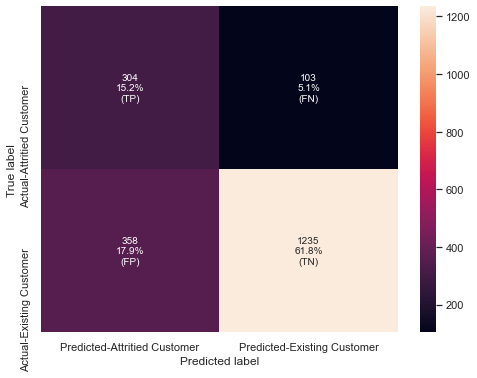

In [67]:
make_confusion_matrix(model_3,X_test,y_test,threshold=optimal_threshold_auc_roc_3,labels=[1, 0])

## 10 Conclusion and key takeaways

- We have trained a Neural Network that performs very well on Training and Test data sets.
- Although, our initial model have relatively good results, we can improve the performance of the model using different techniques like:
    - Adding Early Stopping
    - Change the learning rate in the optimizer
    - Weight initialization
    - Add more hidden layers to the neural network
    - Weighted loss to account for class imbalance
- With the Neural Network we can identify the customers that leave the bank. However, it is not easy to determine what are the main features impacting the decisions of the customers, and other Machine Learning techniques should be used to analyze the importance of features in the decision variable